In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline


In [3]:
def loss(x):
    return x[0]**2 + x[1]**2 + x[2]**2

In [4]:
class SquaredNet(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        
        self.input_features = input_features
        self.output_features = output_features

        self.fc1 = nn.Linear(self.input_features, 8)
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.normal_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias, -f1, f1)        
        

        self.fc2 = nn.Linear(8, 8)
        f2 = 1 / np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.normal_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias, -f2, f2)        
        
                
        self.fc3 = nn.Linear(8, 3)
        f3 = 1 / np.sqrt(self.fc3.weight.data.size()[0])
        torch.nn.init.normal_(self.fc3.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.fc3.bias, -f3, f3)   
        
        self.fc4 = nn.Linear(3, self.output_features)        
        self.device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        
        x = torch.tanh(self.fc1(x)) 
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        y = self.fc4(x) @ self.fc4(x).T
        return y
    
def _jacobian(net, x, noutputs):
    """
    Returns: d(N_W) / d(x)
    
    """
    
    x = x.squeeze()
    n = x.size()[0]
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = net(x)
    y.backward(torch.eye(noutputs))
    return x.grad.data

In [5]:
def _data(size=1000):
    """
    Returns data in the form of x --> L(x)
    where x = x, y, theta = 0
    
    """
    _xtrain = []
    _ytrain = []
    for _ in range(size):
        xyz = [np.random.uniform(-2.1, 2.1), 
               np.random.uniform(-2.1, 2.1),
               0]
        
        cost = loss(xyz)
        
        _xtrain.append(xyz)
        _ytrain.append([cost])
        
    xtrain = torch.tensor(_xtrain, dtype = torch.float32)
    ytrain = torch.tensor(_ytrain, dtype = torch.float32)
        
    return xtrain, ytrain
    

In [6]:
def _train(epochs=200):
    """
    Returns a trained neural network
    
    """
    
    
    # Generate data
    xtrain, ytrain = _data(1000)
    
    
    # Generate a Neural Net
    net = SquaredNet(xtrain.shape[1], ytrain.shape[1])
    net = net.float()
    net.train()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
        
    # Training    
    for epoch in tqdm(range(epochs)):
        for x, y in zip(xtrain, ytrain):
                       
            optimizer.zero_grad()
            y_ = net(x)          
            loss = (y_ - y)**2
            loss.backward()
            optimizer.step()  
    
    del xtrain, ytrain        
    return net
    

In [7]:
# Calculate MSE for test
def evaluationMSE(net, size  = 10000):
    
    x, lx = _data(size)
    
    net.eval()
    
    totalLoss = 0.
    
    with torch.no_grad():
        for test, target in zip(x, lx):
            
            prediction = net(test)
            
            totalLoss += (prediction.item() - target.item()) ** 2
            
    return totalLoss / size

In [8]:
sqn = _train()

100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


In [9]:
print(f"MSE for Squared Network is : {evaluationMSE(sqn, 1000)}")

MSE for Squared Network is : 0.044067279895896205


In [10]:
# Calculate MSDE

def evalMSDE(net, npoints=1000):
    
    jacobianLossFunction = nd.Jacobian(loss)
    
    net.eval()
    
    mean_squared_derivative_error = 0.
    
    for _ in range(npoints):
        xyz = [np.random.uniform(-2.1, 2.1), 
               np.random.uniform(-2.1, 2.1),
               0]
        
        # calculate the derivative of loss with respect to x, del L
        delLf = jacobianLossFunction(xyz).squeeze().tolist()
        
        # convert input to tensor
        test = torch.tensor(xyz, dtype = torch.float32)
        # Get derivative of net prediction
        delNw = _jacobian(net, test, 1).numpy().squeeze().tolist()
        

        
        # Calculate the sum of squared errors for the two arrays
        error = (delLf[0] - delNw[0])**2 + (delLf[1] - delNw[1])**2 + (delLf[2] - delNw[2])**2
        mean_squared_derivative_error += error
        
    return mean_squared_derivative_error / npoints


In [16]:
print(f"MSDE for Squared Network is : {evalMSDE(sqn, 1000)}")    

MSDE for Squared Network is : 64.09394881733657


In [12]:
def scatterNeuralNetwork(net,npoints = 1000):
    """
    Scatter plot of L(x) w.r.t x1, x2
        
    """
    net.eval()
    
    min_x, max_x, dim_x = (-2, 2, npoints)
    min_y, max_y, dim_y = (-2, 2, npoints)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)

    X,Y = np.meshgrid(x,y)

    def z_function(x,y):
        theta = 0
        _sample = [x, y, theta]
        sample = torch.tensor(_sample, dtype = torch.float32)
        with torch.no_grad():
            prediction = net(sample)
        return prediction.detach().numpy().squeeze().tolist()

    z = np.array([z_function(x,y) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)

    plt.pcolormesh(X,Y,Z)
    plt.xlim(-2.2, 2.2)
    plt.ylim(-2.2,2.2)
    plt.xticks(np.arange(-2.5, 2.6, step=1))
    plt.yticks(np.arange(-2.5, 2.6, step=1))
    plt.title("Squared Network")
    cbar = plt.colorbar()
    cbar.set_label('Cost')
    #plt.savefig("Squared Network.png")

    plt.show()

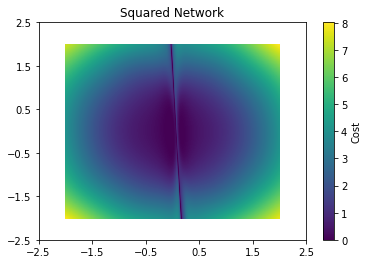

In [13]:
scatterNeuralNetwork(sqn)

In [14]:
def scatterMSE(net, npoints=1000):
    net.eval()
    
    min_x, max_x, dim_x = (-2, 2, npoints)
    min_y, max_y, dim_y = (-2, 2, npoints)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)
    
    def z_function(x, y):
        """
        Generate L(x) - N(w)
        """
        theta = 0
        _sample = [x, y, theta]
        sample = torch.tensor(_sample, dtype = torch.float32)
        
        # Get L(w)
        lx = loss(_sample)
        
        # Get N(w)
        with torch.no_grad():
            prediction = net(sample)
        nw = prediction.item()
        
        return lx - nw
    
    z = np.array([z_function(x,y) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)

    plt.pcolormesh(X,Y,Z)
    plt.xlim(-2.2, 2.2)
    plt.ylim(-2.2,2.2)
    plt.xticks(np.arange(-2.5, 2.6, step=1))
    plt.yticks(np.arange(-2.5, 2.6, step=1))
    plt.title("Squared Net: |L(x) - N(w)|")
    cbar = plt.colorbar()
    cbar.set_label('error')
    #plt.savefig("SQmse.png")

    plt.show()
    

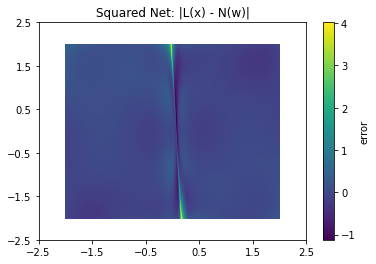

In [15]:
scatterMSE(sqn)

In [ ]:
def scatterMSDE(net, npoints=1000):
    
    jacobianLossFunction = nd.Jacobian(loss)
    net.eval()
    
    
    min_x, max_x, dim_x = (-2, 2, npoints)
    min_y, max_y, dim_y = (-2, 2, npoints)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)
    
    def z_function(x,y):
        theta = 0
        _sample = [x, y, theta]
        sample = torch.tensor(_sample, dtype = torch.float32)
        # calculate the derivative of loss with respect to x, del L
        delLf = jacobianLossFunction(_sample).squeeze().tolist()
        # Get derivative of net prediction
        delNw = _jacobian(net, sample, 1).numpy().squeeze().tolist()
        # Calculate the sum of squared errors for the two arrays
        error = (delLf[0] - delNw[0])**2 + (delLf[1] - delNw[1])**2 + (delLf[2] - delNw[2])**2
        return error
    
    z = np.array([z_function(x,y) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)

    plt.pcolormesh(X,Y,Z)
    plt.xlim(-2.2, 2.2)
    plt.ylim(-2.2,2.2)
    plt.xticks(np.arange(-2.5, 2.6, step=1))
    plt.yticks(np.arange(-2.5, 2.6, step=1))
    plt.title("Squared net: |del L(x) - del N(w)|")
    cbar = plt.colorbar()
    cbar.set_label('error')
    #plt.savefig("sqMSDE.png")
    plt.show()

In [ ]:
scatterMSDE(sqn)